In [15]:
 # importing the library

import csv
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import seaborn as sns
import plotly.express as px
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random

In [16]:
# this will be the directory of our training set and validation set

TRAINING_FILE = 'sign_mnist_train.csv/sign_mnist_train.csv'
VALIDATION_FILE = 'sign_mnist_test.csv/sign_mnist_test.csv'

In [17]:
def parse_data_from_input(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=',')
        imgs = []
        labels = []
        next(reader, None)
        for row in reader:
            label = row[0]
            data = row[1:]
            img = np.array(data).reshape((28, 28))

            imgs.append(img)
            labels.append(label)

    images = np.array(imgs).astype(float)
    labels = np.array(labels).astype(float)
    return images, labels

In [18]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape}")
print(f"Training labels has shape: {training_labels.shape}")
print(f"Validation images has shape: {validation_images.shape}")
print(f"Validation labels has shape: {validation_labels.shape}")

Training images has shape: (27455, 28, 28)
Training labels has shape: (27455,)
Validation images has shape: (7172, 28, 28)
Validation labels has shape: (7172,)


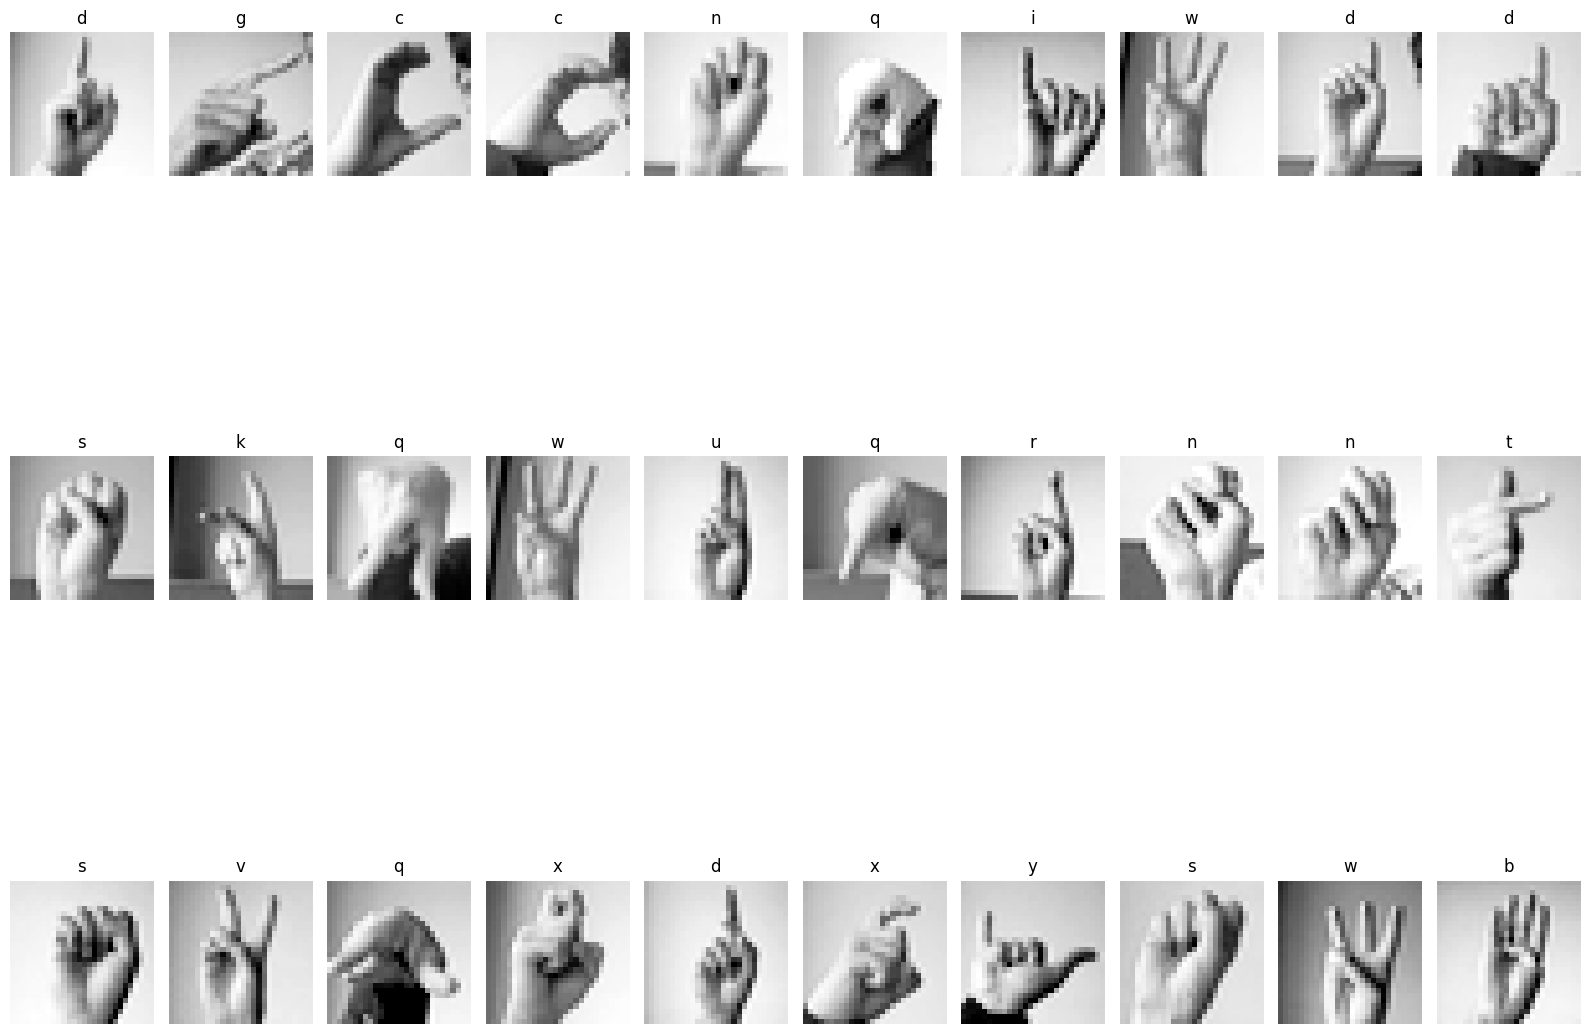

In [19]:
# Plot a sample of 30 images from the training set
def plot_categories(training_images, training_labels):
    fig, axes = plt.subplots(3, 10, figsize=(16, 15))
    axes = axes.flatten()
    letters = list(string.ascii_lowercase)

    for k in range(30):
        img = training_images[k]
        img = np.expand_dims(img, axis=-1)
        img = array_to_img(img)
        ax = axes[k]
        ax.imshow(img, cmap="Greys_r")
        ax.set_title(f"{letters[int(training_labels[k])]}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

plot_categories(training_images, training_labels)

In [20]:
train_df = pd.read_csv('sign_mnist_train.csv/sign_mnist_train.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [21]:
train_df.label.value_counts()

label
17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: count, dtype: int64

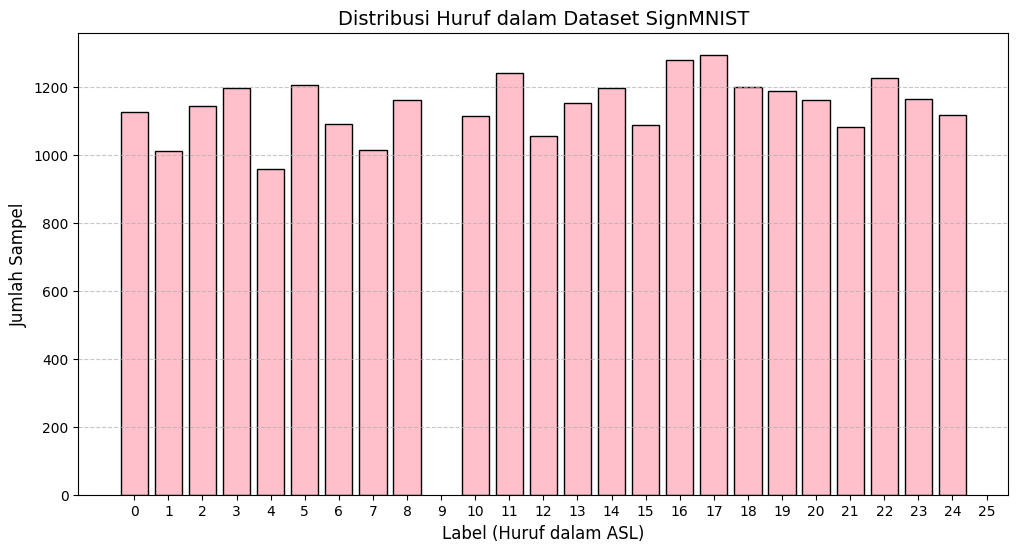

In [22]:
counts = train_df['label'].value_counts().sort_index()

# Inisialisasi ukuran plot
plt.figure(figsize=(12, 6))

# Membuat histogram dengan warna pink dan garis tepi hitam
plt.bar(counts.index, counts.values, color='pink', edgecolor='black')

# Menambahkan judul dan label sumbu
plt.title("Distribusi Huruf dalam Dataset SignMNIST", fontsize=14)
plt.xlabel("Label (Huruf dalam ASL)", fontsize=12)
plt.ylabel("Jumlah Sampel", fontsize=12)

# Menampilkan setiap kategori pada sumbu X
plt.xticks(np.arange(min(counts.index), max(counts.index) + 2, 1))

# Menampilkan grid agar lebih mudah dibaca
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan plot
plt.show()


In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.regularizers import l2

# Function to preprocess and normalize data
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    # Flatten images for MLP: Convert (28, 28) -> (784,)
    training_images = (training_images.reshape(-1, 28*28) - 0.5) / 0.5
    validation_images = (validation_images.reshape(-1, 28*28) - 0.5) / 0.5

    return training_images, training_labels, validation_images, validation_labels

# Define MLP Model
def create_mlp_model():
    model = tf.keras.models.Sequential([
        Dense(2048, activation='relu', input_shape=(28*28,), kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1024, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(512, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(26, activation='softmax')  # Output layer for 26 classes (assuming a classification problem with 26 classes)
    ])

    # Optimizer
    optimizer = Adam(learning_rate=0.001)  # Using Adam optimizer with a learning rate of 0.001

    # Compile Model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',  # Assuming labels are integers (not one-hot encoded)
        metrics=['accuracy']
    )

    return model

# Setup for EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Example for training the model (replace with your actual data)
# train_images, train_labels, val_images, val_labels should be your dataset
train_images, train_labels, val_images, val_labels = train_val_generators(training_images, training_labels, validation_images, validation_labels)

# Define model
model = create_mlp_model()

# Train the model
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=50,  # Number of epochs to train for
                    batch_size=64,  # Adjust batch size if needed
                    callbacks=[early_stopping, reduce_lr])  # Callbacks for early stopping and learning rate reduction


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.1402 - loss: 3.3928 - val_accuracy: 0.1775 - val_loss: 3.0456 - learning_rate: 0.0010
Epoch 2/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.4495 - loss: 1.6461 - val_accuracy: 0.1132 - val_loss: 5.9914 - learning_rate: 0.0010
Epoch 3/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.4989 - loss: 1.5275 - val_accuracy: 0.0938 - val_loss: 6.3059 - learning_rate: 0.0010
Epoch 4/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.4645 - loss: 1.6088 - val_accuracy: 0.5240 - val_loss: 1.4754 - learning_rate: 0.0010
Epoch 5/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5022 - loss: 1.4936 - val_accuracy: 0.5074 - val_loss: 1.5686 - learning_rate: 0.0010
Epoch 6/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5147 - loss: 1.4435 - val_accuracy: 0.5247 - val_loss: 1.8074 - learning_rate: 0.0010
Epoch 7/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.5365 - l

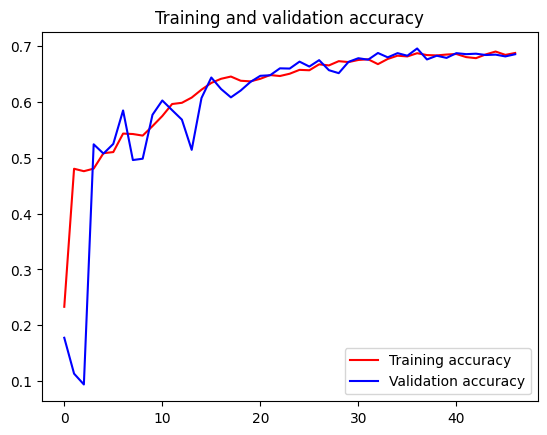

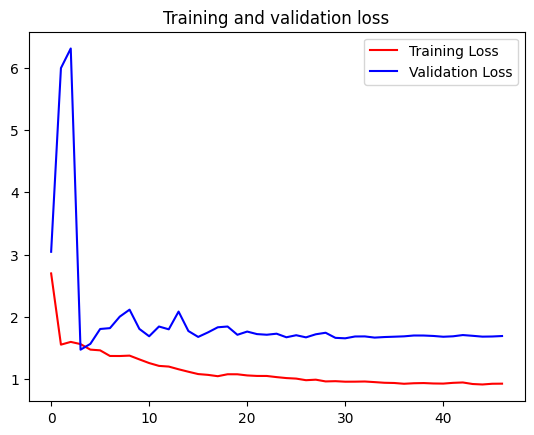

In [24]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


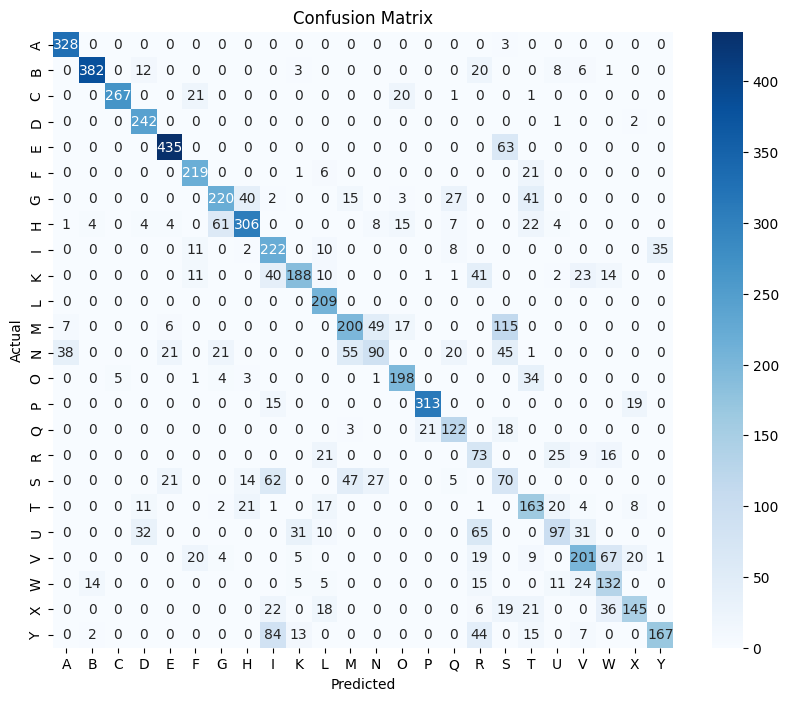

In [27]:
# Confusion matrix
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(val_labels.astype(int), y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list("ABCDEFGHIKLMNOPQRSTUVWXY"),
            yticklabels=list("ABCDEFGHIKLMNOPQRSTUVWXY"))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


✅ Displaying 10 Correctly Classified Images


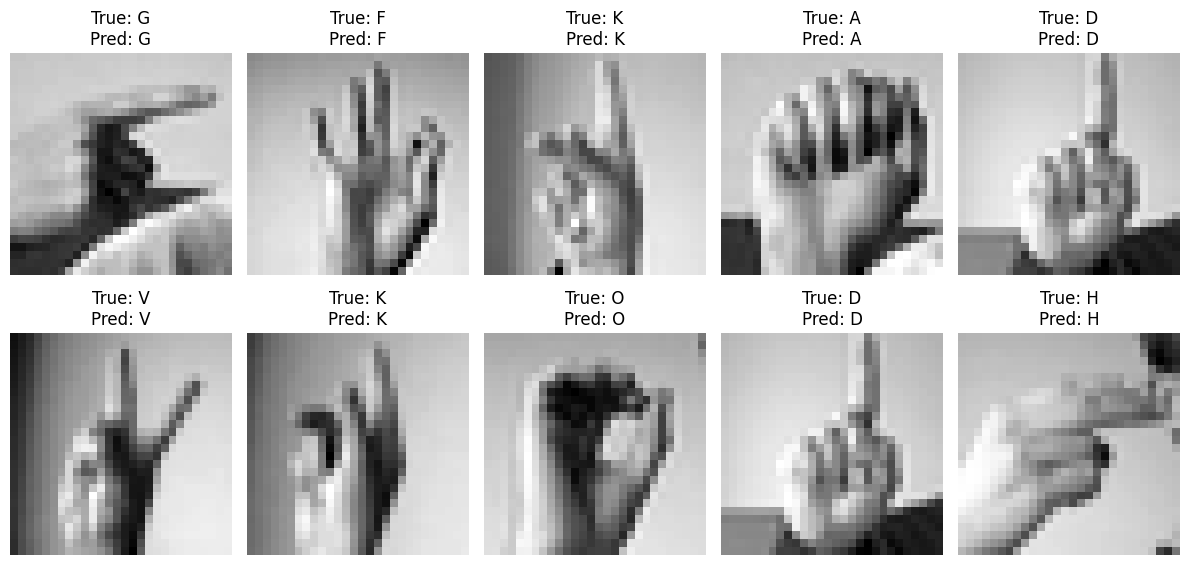


❌ Displaying 10 Misclassified Images


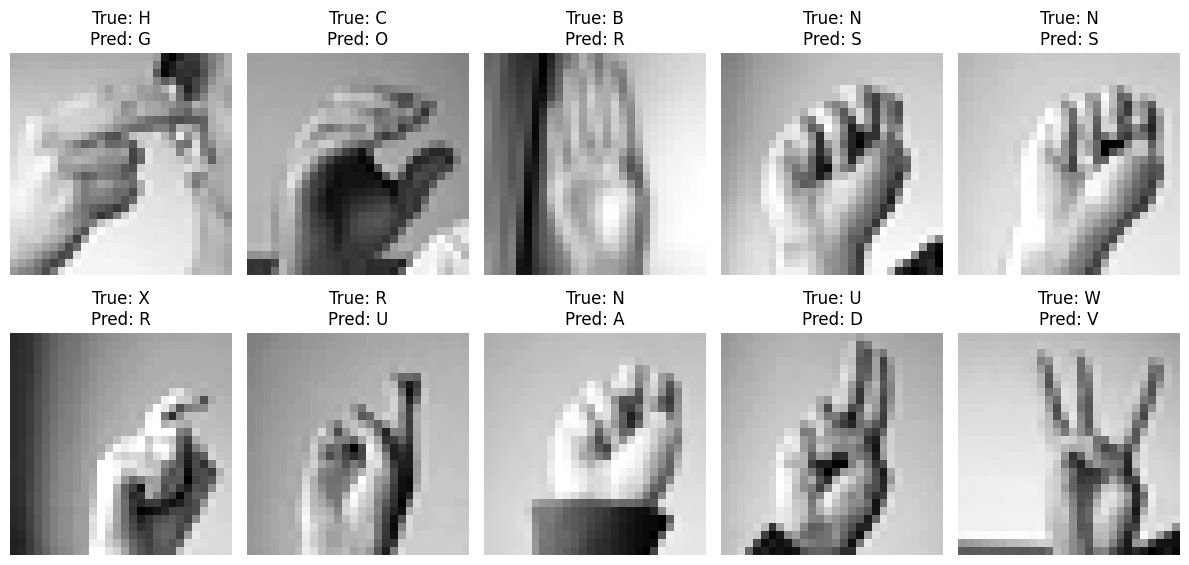

In [28]:
# Find correct predictions
correct_indices = np.where(val_labels == y_pred_classes)[0]

# Display 10 correctly classified images
if len(correct_indices) > 0:
    print(f"\n✅ Displaying 10 Correctly Classified Images")

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(correct_indices[:10]):  # Show first 10 correct predictions
        plt.subplot(2, 5, i+1)
        plt.imshow(val_images[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {chr(int(val_labels[idx]) + 65)}\nPred: {chr(int(y_pred_classes[idx]) + 65)}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("\n🎉 No correctly classified images? Something is wrong!")

# Find misclassified predictions
wrong_preds = np.where(val_labels != y_pred_classes)[0]

# Display 10 misclassified images
if len(wrong_preds) > 0:
    print(f"\n❌ Displaying 10 Misclassified Images")

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(wrong_preds[:10]):  # Show first 10 incorrect predictions
        plt.subplot(2, 5, i+1)
        plt.imshow(val_images[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {chr(int(val_labels[idx]) + 65)}\nPred: {chr(int(y_pred_classes[idx]) + 65)}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("\n🎉 No misclassified images! Perfect accuracy on validation set.")



🎲 Displaying 5 Random Predictions


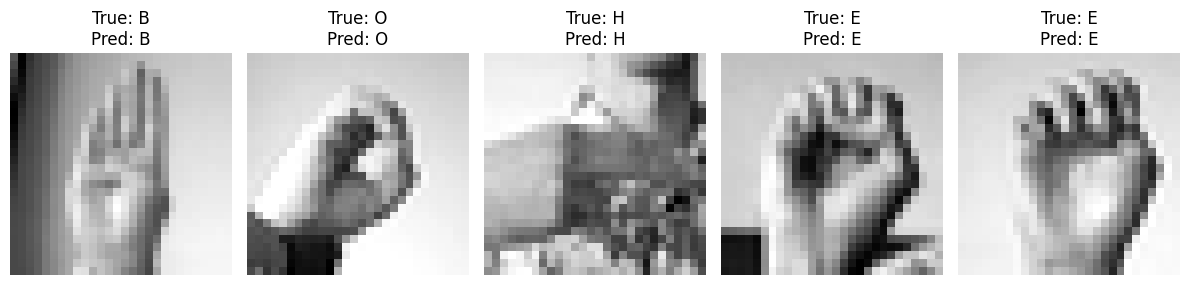

In [31]:
# Display 5 random samples
total_samples = len(val_images)

random_indices = random.sample(range(total_samples), 5)

print("\n🎲 Displaying 5 Random Predictions")
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(val_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {chr(int(val_labels[idx]) + 65)}\nPred: {chr(int(y_pred_classes[idx]) + 65)}")
    plt.axis("off")

plt.tight_layout()
plt.show()